# Twitter customer care dataset

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import os
from datetime import datetime
from tqdm import tqdm_notebook
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

/home/andrew/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# os.getcwd()
os.listdir('kaggle_customer_support/')

['twcs.csv']

# The goal of this exercise:
1. Parse the data set into similarly themed conversational interactions (to what our Care organization might see with customers)
2. Evaluate the dataset with two different models (transformer and NLTK.vader), both of which are unsupervised transfer learning models for sentiment - with the goal of seeing how much the models concur


### create dataframe with dataset consisting of customer support tweets

In [3]:
tweets = pd.read_csv('kaggle_customer_support/twcs.csv')

In [4]:
tweets.shape

(2811774, 7)

In [5]:
tweets.head(10) # Evaluate the dataset

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16.0


In [6]:
# Evaluate some data to understand the type of text inside of the cell
tweets.iloc[8]['text']

'@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯'

### I am going to focus on the customer tweets only for this experiment 

In [7]:
customer_view = tweets[tweets.inbound]

In [8]:
customer_view.shape

(1537843, 7)

###  to isolate the dataset further, I am choosing to initially focus on a telecommunications sub dataset

In [9]:
customer = customer_view[customer_view['text'].str.contains("@sprintcare")]

In [10]:
customer.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0


In [12]:
### Keep the size of the dataset large so we have ample training and test data

In [14]:
result = customer.dtypes

In [15]:
result

tweet_id                     int64
author_id                   object
inbound                       bool
created_at                  object
text                        object
response_tweet_id           object
in_response_to_tweet_id    float64
dtype: object

In [16]:
customer['created_at'] = pd.to_datetime(customer.created_at)
customer= customer.sort_values(by = 'created_at')

/tmp/ipykernel_10080/1001897530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer['created_at'] = pd.to_datetime(customer.created_at)


In [17]:
customer.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1157188,1278330,419157,True,2011-11-28 18:39:16+00:00,@sprintcare I can not make any calls whats the...,1278329,NaN
1402575,1544038,478295,True,2015-09-16 02:57:20+00:00,@115714 @sprintcare I get almost no service af...,"1544039,1544040,1544041,1544035",NaN
2582572,2753722,770395,True,2015-10-26 17:07:32+00:00,@sprintcare to replace this one without paying...,2753721,2753723.0
2582570,2753720,770395,True,2015-10-26 17:14:03+00:00,@sprintcare done,2753719,2753721.0
2582569,2753719,770395,True,2015-10-26 17:30:32+00:00,@sprintcare get any early upgrade. My less th...,2753718,2753720.0


#### in order to normalize the data for later use in transformer comparison, I am going to:
- remove @sprintcare
- remove frequent words
- remove stopwords
- remove URLs

In [18]:
# 1. Get the most frequent terms
counter = Counter()
for text in customer["text"].values:
    for word in text.split():
        counter[word] +=1
top_25 = counter.most_common(25)
top_25_list = [tup[0] for tup in top_25]

# 2. Get the least frequent terms
Y = customer['text']
vectorizer = CountVectorizer(min_df = 2)
matrix = vectorizer.fit_transform(Y)
counts = pd.DataFrame(matrix.toarray(), columns = vectorizer.get_feature_names_out())
stop_w = list(vectorizer.stop_words_)
all_stops = stop_w + top_25_list

In [19]:
n_rare_words = 25
rare_words = set([w for (w,c) in counter.most_common()][:- n_rare_words: -1])
print(rare_words)

{'$160.', 'mistakes,', '#payingabillandgettingnothinginreturn', '🤙🏽', 'mins!!', '#threeweeks', '$320', 'https://t.co/XXFAQShfFw', 'Fashooo!', 'ago!!!', '#happenedagainwhiletweeting', "Hasn't", 'this).', 'store?!?', '888-211-4727', 'later....', 'Left', "I'm#stilldealingwith.", 'suggestion,', '#reset.', 'performed', '28557', '#nopestillnodata', '100000'}


#### The Twitter dataset has many @something, #something, and URLs. We need to remove them.


In [20]:
customer.reset_index(drop=True, inplace = True)

In [21]:
def clean_twitter(tweet):
    clean_tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", clean_tweet)
    words = clean_tweet.split()
    words = ' '.join([w for w in words if w not in all_stops])
    return words

customer['clean'] = customer['text'].progress_apply(lambda tweet: clean_twitter(tweet))

  0%|          | 0/13711 [00:00<?, ?it/s]

In [22]:
customer.head(7)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,clean
0,1278330,419157,True,2011-11-28 18:39:16+00:00,@sprintcare I can not make any calls whats the...,1278329,NaN,can make any calls whats problem please let ou...
1,1544038,478295,True,2015-09-16 02:57:20+00:00,@115714 @sprintcare I get almost no service af...,"1544039,1544040,1544041,1544035",NaN,get almost no after moving LA. What wrong awfu...
2,2753722,770395,True,2015-10-26 17:07:32+00:00,@sprintcare to replace this one without paying...,2753721,2753723.0,replace one without paying an early upgrade fe...
3,2753720,770395,True,2015-10-26 17:14:03+00:00,@sprintcare done,2753719,2753721.0,done
4,2753719,770395,True,2015-10-26 17:30:32+00:00,@sprintcare get any early upgrade. My less th...,2753718,2753720.0,get any early upgrade. My less than year old d...
5,2753717,770395,True,2015-10-26 19:54:24+00:00,@sprintcare Thanks very much for your help!,2753715,2753718.0,Thanks very much help!
6,726098,293934,True,2015-10-31 20:20:27+00:00,@sprintcare . I live in a city not BFE and I'm...,726097,NaN,. live city BFE I'm sick tired getting this. h...


### run the Vader sentiment analyzer on customer text as a baseline
### this function will add the vader compound scores to the dataframe

In [23]:
sentiment_analyzer = SentimentIntensityAnalyzer()
def sentiment_analyze(text:  str) -> float:
    return sentiment_analyzer.polarity_scores(text)['compound']

In [24]:
customer['vader_sentiment_clean'] = customer.clean.progress_apply(sentiment_analyze)
customer['vader_sentiment_noclean'] = customer.text.progress_apply(sentiment_analyze)

  0%|          | 0/13711 [00:00<?, ?it/s]

  0%|          | 0/13711 [00:00<?, ?it/s]

In [25]:
# Drop unnecessary columns
customer.drop(['inbound', 'created_at', 'response_tweet_id', 'in_response_to_tweet_id'], inplace=True,
             axis = 1)
customer.head(10)


,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean
0,1278330,419157,@sprintcare I can not make any calls whats the...,can make any calls whats problem please let ou...,-0.1027,-0.1027
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109
2,2753722,770395,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772
3,2753720,770395,@sprintcare done,done,0.0000,0.0000
4,2753719,770395,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000
5,2753717,770395,@sprintcare Thanks very much for your help!,Thanks very much help!,0.7327,0.7088
6,726098,293934,@sprintcare . I live in a city not BFE and I'm...,. live city BFE I'm sick tired getting this. h...,-0.8893,-0.4085
7,726097,293934,@sprintcare at my home all day long.,at home all day long.,0.0000,0.0000
8,726095,293934,@sprintcare it wont help. I've ben reporting s...,wont help. I've ben reporting since last Novem...,-0.6319,-0.6319
9,726094,293934,@sprintcare again,again,0.0000,0.0000


In [26]:
customer.tail()

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean
13706,596987,261524,@sprintcare You guys can’t fix what you’ve don...,You guys can’t fix what you’ve done. I’m alrea...,0.4767,0.4767
13707,603292,263319,@sprintcare Fashooo! You guys have helped way ...,Fashooo! You guys helped way more than . I'll ...,0.0000,0.0000
13708,86600,134926,@sprintcare @sprintcare @115714 Do you think y...,Do think you’ll ever put new towers coastal NC...,0.0000,0.0000
13709,603291,263319,@sprintcare Much appreciated 🤙🏽,Much appreciated 🤙🏽,0.5106,0.5106
13710,603286,263317,@sprintcare i’ve repeated my problem 100000 ti...,i’ve repeated problem times over doing that.,-0.4019,-0.4019


In [28]:
# Examine the results to determine if there are any significant differences
temp = customer.loc[(customer['vader_sentiment_clean'])!=(customer['vader_sentiment_noclean'])]

# Helper function to compare the differences in results of each model input
def compare_vader(num_a:  float, num_b:  float)-> float:
    diff = abs(num_a-num_b) 
    return diff
temp['vader_compare']= temp.progress_apply(lambda x:  compare_vader(x['vader_sentiment_clean'], x ['vader_sentiment_noclean']), axis = 1)
print ("Cleaning the data had a", ((temp.shape[0] / customer.shape[0])* 100), "percent effect on how the scores were calculated")

  0%|          | 0/1136 [00:00<?, ?it/s]

Cleaning the data had a 8.285318357523156 percent effect on how the scores were calculated


/tmp/ipykernel_10080/2562101752.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['vader_compare']= temp.progress_apply(lambda x:  compare_vader(x['vader_sentiment_clean'],


In [29]:
print(customer.loc[0]['clean'])
print(customer.loc[0]['text'])

can make any calls whats problem please let out contact
@sprintcare I can not make any calls whats the problem #sprint #4G @115714 please let me out of my contact


In [30]:
customer.loc[0]['vader_sentiment_clean']

-0.1027

In [31]:
customer.clean[1]

'get almost no after moving LA. What wrong awful coverage? Why should stay guys?'

In [32]:
customer.vader_sentiment_clean[1]

-0.8109

In [33]:
customer.clean[4]

'get any early upgrade. My less than year old does work? How right? You already $400 $$'

In [34]:
customer.vader_sentiment_clean[4]

0.0

In [35]:
### Assign Vader compound scores to positive(2), negative(1) or neutral class(0)

In [36]:
# # Fill the value with 1 if vader_no_cleaned > 0 else with 0 (negative)
customer['clean_class']= customer['vader_sentiment_clean'].progress_apply(lambda c:  2 if c >0 else 1 if c ==0 else 0)
customer['noclean_class']= customer['vader_sentiment_noclean'].progress_apply(lambda c:  2 if c >0 else 1 if c ==0 else 0)

  0%|          | 0/13711 [00:00<?, ?it/s]

  0%|          | 0/13711 [00:00<?, ?it/s]

In [37]:
# Identify any classifications that do not agree
customer['vader_class_compare']= customer.progress_apply(lambda x: compare_vader(x['clean_class'], x ['noclean_class']), axis = 1)

  0%|          | 0/13711 [00:00<?, ?it/s]

In [38]:
customer.head(10)

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,clean_class,noclean_class,vader_class_compare
0,1278330,419157,@sprintcare I can not make any calls whats the...,can make any calls whats problem please let ou...,-0.1027,-0.1027,0,0,0
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,0
2,2753722,770395,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,2,2,0
3,2753720,770395,@sprintcare done,done,0.0000,0.0000,1,1,0
4,2753719,770395,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,0
5,2753717,770395,@sprintcare Thanks very much for your help!,Thanks very much help!,0.7327,0.7088,2,2,0
6,726098,293934,@sprintcare . I live in a city not BFE and I'm...,. live city BFE I'm sick tired getting this. h...,-0.8893,-0.4085,0,0,0
7,726097,293934,@sprintcare at my home all day long.,at home all day long.,0.0000,0.0000,1,1,0
8,726095,293934,@sprintcare it wont help. I've ben reporting s...,wont help. I've ben reporting since last Novem...,-0.6319,-0.6319,0,0,0
9,726094,293934,@sprintcare again,again,0.0000,0.0000,1,1,0


###  Print out the total number of Vader predictions against unclean and clean data 

In [39]:
analyze_diff = customer.loc[(customer['clean_class'])!=(customer['noclean_class'])]

print(analyze_diff.shape[0])

print ("Cleaning the data had a", ((analyze_diff.shape[0] / customer.shape[0])* 100), "percent effect on Vader predictions")

analyze_diff.reset_index(drop=True, inplace = True)

416
Cleaning the data had a 3.0340602436000292 percent effect on Vader predictions


### Evaluate the dataset for balance; both datasets should be fairly balanced

In [40]:
# count the number of unique values for classes to evaluate balance of data
# data classes are fairly evenly distributed
li = list(customer['clean_class'].value_counts())
li2 = list(customer['noclean_class'].value_counts())
print (li)
print (li2)

[4839, 4617, 4255]
[4709, 4553, 4449]


### Run the Transformer model

In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
sentiment_task("get any early upgrade. My less than a year old phone does not work? How is this right? You already have $400 of my $$")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'negative', 'score': 0.9258463978767395}]

In [101]:
# This is a test of the sentiment analysis
sentiment_task("I'm here")

[{'label': 'neutral', 'score': 0.6042205691337585}]

In [100]:
import time
start_time = time.time()

customer['roberta_pred'] = customer['clean'].progress_apply(sentiment_task)
customer['roberta_pred_no_clean'] = customer['text'].progress_apply(sentiment_task)

print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/13711 [00:00<?, ?it/s]

  0%|          | 0/13711 [00:00<?, ?it/s]

--- 1859.7642531394958 seconds ---


In [ ]:
customer.head()

In [47]:
# Break the list of dictionaries into new classified columns
customer[['r_clean_format_label', 'r_clean_format_score']] = customer['roberta_pred'].agg(pd.Series)[0].agg(pd.Series)                                                              
customer[['r_noclean_label', 'r_noclean_score']] = customer['roberta_pred_no_clean'].agg(pd.Series)[0].agg(pd.Series)

In [48]:
customer.head()

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,clean_class,noclean_class,vader_class_compare,roberta_pred,roberta_pred_no_clean,r_clean_format_label,r_clean_format_score,r_noclean_label,r_noclean_score
0,1278330,419157,@sprintcare I can not make any calls whats the...,can make any calls whats problem please let ou...,-0.1027,-0.1027,0,0,0,"[{'label': 'neutral', 'score': 0.6446839570999...","[{'label': 'negative', 'score': 0.826441466808...",neutral,0.644684,negative,0.826441
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,0,"[{'label': 'negative', 'score': 0.937077283859...","[{'label': 'negative', 'score': 0.957944631576...",negative,0.937077,negative,0.957945
2,2753722,770395,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,2,2,0,"[{'label': 'neutral', 'score': 0.5881701707839...","[{'label': 'negative', 'score': 0.630531489849...",neutral,0.588170,negative,0.630531
3,2753720,770395,@sprintcare done,done,0.0000,0.0000,1,1,0,"[{'label': 'positive', 'score': 0.446636557579...","[{'label': 'neutral', 'score': 0.7879336476325...",positive,0.446637,neutral,0.787934
4,2753719,770395,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,0,"[{'label': 'negative', 'score': 0.476427942514...","[{'label': 'negative', 'score': 0.936681628227...",negative,0.476428,negative,0.936682


In [49]:
# Fill the value with 2 if label == POSITIVE, 1 if label == NEUTRAL else with 0 (NEGATIVE)

customer['roberta_class_clean']= customer['r_clean_format_label'].apply(lambda c:  2 if c == 'positive' else 1 if c =='neutral' else 0)
customer['roberta_class_noclean']= customer['r_noclean_label'].apply(lambda c:  2 if c == 'positive' else 1 if c =='neutral' else 0)

In [50]:
customer.head(2)

,tweet_id,author_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,clean_class,noclean_class,vader_class_compare,roberta_pred,roberta_pred_no_clean,r_clean_format_label,r_clean_format_score,r_noclean_label,r_noclean_score,roberta_class_clean,roberta_class_noclean
0,1278330,419157,@sprintcare I can not make any calls whats the...,can make any calls whats problem please let ou...,-0.1027,-0.1027,0,0,0,"[{'label': 'neutral', 'score': 0.6446839570999...","[{'label': 'negative', 'score': 0.826441466808...",neutral,0.644684,negative,0.826441,1,0
1,1544038,478295,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,0,"[{'label': 'negative', 'score': 0.937077283859...","[{'label': 'negative', 'score': 0.957944631576...",negative,0.937077,negative,0.957945,0,0


In [51]:
analyze_results = customer.drop(['author_id', 'vader_class_compare',
                                 'roberta_pred', 'roberta_pred_no_clean',
                                 'r_clean_format_score', 'r_noclean_score'], axis = 1)

In [52]:
analyze_results.head()

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,clean_class,noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean
0,1278330,@sprintcare I can not make any calls whats the...,can make any calls whats problem please let ou...,-0.1027,-0.1027,0,0,neutral,negative,1,0
1,1544038,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,negative,negative,0,0
2,2753722,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,2,2,neutral,negative,1,0
3,2753720,@sprintcare done,done,0.0000,0.0000,1,1,positive,neutral,2,1
4,2753719,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,negative,negative,0,0


In [53]:
analyze_results["clean_match"] = analyze_results ["clean_class"] == analyze_results["roberta_class_clean"]
analyze_results["noclean_match"] = analyze_results ["noclean_class"] == analyze_results["roberta_class_noclean"]
analyze_results.head(7)

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,clean_class,noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean,clean_match,noclean_match
0,1278330,@sprintcare I can not make any calls whats the...,can make any calls whats problem please let ou...,-0.1027,-0.1027,0,0,neutral,negative,1,0,False,True
1,1544038,@115714 @sprintcare I get almost no service af...,get almost no after moving LA. What wrong awfu...,-0.8109,-0.8109,0,0,negative,negative,0,0,True,True
2,2753722,@sprintcare to replace this one without paying...,replace one without paying an early upgrade fe...,0.0772,0.0772,2,2,neutral,negative,1,0,False,False
3,2753720,@sprintcare done,done,0.0000,0.0000,1,1,positive,neutral,2,1,False,True
4,2753719,@sprintcare get any early upgrade. My less th...,get any early upgrade. My less than year old d...,0.0000,0.0000,1,1,negative,negative,0,0,False,False
5,2753717,@sprintcare Thanks very much for your help!,Thanks very much help!,0.7327,0.7088,2,2,positive,positive,2,2,True,True
6,726098,@sprintcare . I live in a city not BFE and I'm...,. live city BFE I'm sick tired getting this. h...,-0.8893,-0.4085,0,0,negative,negative,0,0,True,True


### Check the two models for differences

In [70]:
analyze_results.groupby(by=["clean_match"]).count()

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,clean_class,noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean,noclean_match
clean_match,,,,,,,,,,,,
False,6066,6066,6066,6066,6066,6066,6066,6066,6066,6066,6066,6066
True,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645,7645


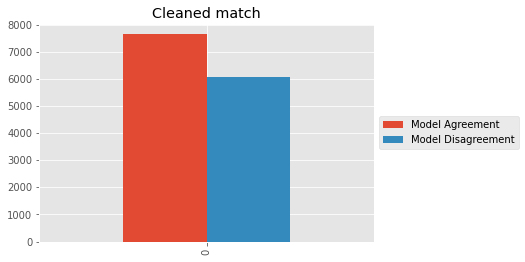

In [98]:
df4 = pd.DataFrame({"Model Agreement": [7645],"Model Disagreement": [6066],},columns=["Model Agreement", "Model Disagreement"])

df4.plot.bar()
plt.title('Cleaned match', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [56]:
analyze_results.groupby(by=["noclean_match"]).count()

,tweet_id,text,clean,vader_sentiment_clean,vader_sentiment_noclean,clean_class,noclean_class,r_clean_format_label,r_noclean_label,roberta_class_clean,roberta_class_noclean,clean_match
noclean_match,,,,,,,,,,,,
False,6321,6321,6321,6321,6321,6321,6321,6321,6321,6321,6321,6321
True,7390,7390,7390,7390,7390,7390,7390,7390,7390,7390,7390,7390


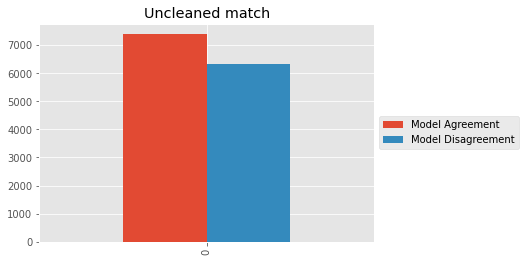

In [96]:
df4 = pd.DataFrame({"Model Agreement": [7390],"Model Disagreement": [6321],},columns=["Model Agreement", "Model Disagreement"])

df4.plot.bar()
plt.title('Uncleaned match', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()